In [62]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import timeit

In [63]:
class TestDataGenerator:
    """
    A class to represent a synthetic data generator.

    ...

    Attributes
    ----------

    [to be defined as part of the coursework]

    Methods
    -------

    [to be defined as part of the coursework]

    """

    def __init__(self, n, h, size):
        if n == 2:
            self.n = 2
            self.h = 2
        elif n == 3:
            self.n = 3
            self.h = 3
        else:
            self.n = n
            self.h = h
        self.size = size

    def generate_random_convex_polygon(self):
        # Generate two lists of random X and Y coordinates
        x_pool = [random.randint(0, self.size) for _ in range(self.h)]
        y_pool = [random.randint(0, self.size) for _ in range(self.h)]

        # Sort them
        x_pool.sort()
        y_pool.sort()

        # Isolate the extreme points
        min_x = x_pool[0]
        max_x = x_pool[-1]
        min_y = y_pool[0]
        max_y = y_pool[-1]

        # Divide the interior points into two chains & Extract the vector components
        x_vec = []
        y_vec = []

        last_top = min_x
        last_bot = min_x

        for i in range(1, self.h - 1):
            x = x_pool[i]

            if random.choice([True, False]):
                x_vec.append(x - last_top)
                last_top = x
            else:
                x_vec.append(last_bot - x)
                last_bot = x

        x_vec.append(max_x - last_top)
        x_vec.append(last_bot - max_x)

        last_left = min_y
        last_right = min_y

        for i in range(1, self.h - 1):
            y = y_pool[i]

            if random.choice([True, False]):
                y_vec.append(y - last_left)
                last_left = y
            else:
                y_vec.append(last_right - y)
                last_right = y

        y_vec.append(max_y - last_left)
        y_vec.append(last_right - max_y)

        # Randomly pair up the X- and Y-components
        random.shuffle(y_vec)

        # Combine the paired up components into vectors
        vec = [(x_vec[i], y_vec[i]) for i in range(self.h)]

        # Sort the vectors by angle
        vec.sort(key=lambda v: math.atan2(v[1], v[0]))

        # Lay them end-to-end
        x = 0
        y = 0
        min_polygon_x = 0
        min_polygon_y = 0
        points = []

        for v in vec:
            points.append((x, y))
            x += v[0]
            y += v[1]
            min_polygon_x = min(min_polygon_x, x)
            min_polygon_y = min(min_polygon_y, y)

        # Move the polygon to the original min and max coordinates
        x_shift = min_x - min_polygon_x
        y_shift = min_y - min_polygon_y

        hull = [(p[0] + x_shift, p[1] + y_shift) for p in points]

        return hull

    def __decompose_polygon_to_triangles(self, polygon):
        """
        Decomposes a convex polygon into triangles.
        :param polygon: List of tuples representing the vertices of the polygon [(x1, y1), (x2, y2), ..., (xn, yn)]
        :return: List of triangles, each represented as a list of three vertex tuples [(x, y)]
        """
        triangles = []
        for i in range(1, len(polygon) - 1):
            triangles.append([polygon[0], polygon[i], polygon[i + 1]])
        return triangles

    def __calculate_triangle_area(self, triangle):
        """
        Calculates the area of a triangle given its vertices.
        :param triangle: List of three vertex tuples [(x1, y1), (x2, y2), (x3, y3)]
        :return: The area of the triangle
        """
        x1, y1 = triangle[0]
        x2, y2 = triangle[1]
        x3, y3 = triangle[2]
        return abs((x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2)) / 2.0)


    def __is_point_inside_polygon(self, point, polygon):
        """
        Determines if a point is inside a convex polygon.
        :param x: The x-coordinate of the point.
        :param y: The y-coordinate of the point.
        :param polygon: The polygon vertices as a list of tuples [(x1, y1), (x2, y2), ..., (xn, yn)]
        :return: True if the point is inside the polygon, False otherwise.
        """
        x, y = point
        crossing_number = 0
        for i, (x1, y1) in enumerate(polygon):
            x2, y2 = polygon[(i + 1) % len(polygon)]
            if ((y1 <= y < y2) or (y2 <= y < y1)) and (x < (x2 - x1) * (y - y1) / (y2 - y1) + x1):
                crossing_number += 1
        return crossing_number % 2 == 1

    def __adjust_point_to_polygon(self, point, polygon):
        """
        Adjusts a point to ensure it is inside the polygon. Checks nearby positions for a valid location inside the polygon.
        :param x: The x-coordinate of the point.
        :param y: The y-coordinate of the point.
        :param polygon: The polygon vertices as a list of tuples.
        :return: Adjusted (x, y) coordinates as a tuple.
        """
        if self.__is_point_inside_polygon(point, polygon):
            return point

        # Directions to check: up, down, left, right
        directions = [(0, -1), (0, 1), (-1, 0), (1, 0)]

        for dx, dy in directions:
            adjusted_x, adjusted_y = point[0] + dx, point[1] + dy
            if self.__is_point_inside_polygon((adjusted_x, adjusted_y), polygon):
                return (adjusted_x, adjusted_y)

        # If no immediate adjustment is successful, recursively adjust in all directions
        for dx, dy in directions:
            adjusted_x, adjusted_y = self.__adjust_point_to_polygon(self, (point[0] + dx, point[1] + dy), polygon)
            if self.__is_point_inside_polygon((adjusted_x, adjusted_y), polygon):
                return adjusted_x, adjusted_y

        # As a last resort, return the original point (should not happen for convex polygons)
        return point


    def generate_points_in_polygon(self, polygon):
        triangles = self.__decompose_polygon_to_triangles(polygon)
        total_area = sum(self.__calculate_triangle_area(tri) for tri in triangles)
        points = []

        #exlude last triangle
        for tri in triangles[:-1]:
            tri_area = self.__calculate_triangle_area(tri)
            points_in_tri = int(round((tri_area / total_area) * (self.n-self.h)))

            for _ in range(points_in_tri):
                r1, r2 = random.random(), random.random()
                sqrt_r1 = math.sqrt(r1)
                A, B, C = tri
                point = ((1 - sqrt_r1) * A[0] + sqrt_r1 * (1 - r2) * B[0] + sqrt_r1 * r2 * C[0],
                        (1 - sqrt_r1) * A[1] + sqrt_r1 * (1 - r2) * B[1] + sqrt_r1 * r2 * C[1])
                point = (int(round(point[0])), int(round(point[1])))
                if self.__is_point_inside_polygon(point, polygon):
                    points.append(point)
                else:
                    adjusted_point = self.__adjust_point_to_polygon(point, polygon)
                    points.append(adjusted_point)

        tri_area = self.__calculate_triangle_area(triangles[-1])
        points_in_tri = self.n-self.h - len(points)
        for _ in range(points_in_tri):
                r1, r2 = random.random(), random.random()
                sqrt_r1 = math.sqrt(r1)
                A, B, C = triangles[-1]
                point = ((1 - sqrt_r1) * A[0] + sqrt_r1 * (1 - r2) * B[0] + sqrt_r1 * r2 * C[0],
                        (1 - sqrt_r1) * A[1] + sqrt_r1 * (1 - r2) * B[1] + sqrt_r1 * r2 * C[1])
                point = (int(round(point[0])), int(round(point[1])))
                if self.__is_point_inside_polygon(point, polygon):
                    points.append(point)
                else:
                    adjusted_point = self.__adjust_point_to_polygon(point, polygon)
                    points.append(adjusted_point)

        return points

    def generate(self):
        polygon = self.generate_random_convex_polygon()
        points_in_polygon = self.generate_points_in_polygon(polygon)
        while len(points_in_polygon) !=  self.n - self.h:
            polygon = self.generate_random_convex_polygon()
            points_in_polygon = self.generate_points_in_polygon(polygon)

        all_points= polygon + points_in_polygon

        print(f'n = {len(all_points)}, h = {len(polygon)}, points in polygon = {len(points_in_polygon)}')
        random.shuffle(all_points)
        return all_points

In [64]:
def grahamscan(inputSet):
    
    pointAnglesDict = {} # Stores points in a list according to their angles - Points with the same angle will be appended to the list
    firstPoint = min(inputSet, key=lambda p: (p[1], p[0])) # Get the lowest and leftmost point
    outputSet = [firstPoint]

    for point in inputSet:
        if point == firstPoint:
            continue
        
        angle_rad = math.atan2(point[1] - firstPoint[1], point[0] - firstPoint[0] )

        if angle_rad in pointAnglesDict:
            pointAnglesDict[angle_rad].append(point)
        else:
            pointAnglesDict[angle_rad] = [point]

    sortedPointAngles = sorted(list(pointAnglesDict.items()))

    point = None
    for pointDict in sortedPointAngles:
        if len(pointDict[1]) > 1:
            point = findFurthest(firstPoint, pointDict[1])
        else:
            point = pointDict[1][0]


        while len(outputSet) >= 2 and getCrossProduct(outputSet[-2], outputSet[-1], point) <= 0:
            outputSet.pop()  # Remove the last point in the outputSet because it makes a non-left turn
        outputSet.append(point)

    return outputSet

In [65]:
def getCrossProduct(p0,p1,p2):
    # Returns which is more counterclockwise
    cross_product = (p1[0] - p0[0]) * (p2[1]-p0[1]) - (p2[0]-p0[0]) * (p1[1]-p0[1])

    if cross_product == 0:
        return 0 #p1
    elif cross_product > 0:
        return 1 #p2
    else:
        return -1 #p1

In [66]:
def findFurthest(origin, points):
    def distance(point):
        return math.sqrt((origin[0] - point[0]) ** 2 + (origin[1] - point[1]) ** 2)
    
    return max(points, key=distance, default=None)

In [67]:
import timeit
import matplotlib.pyplot as plt

class ExperimentalFramework():
    """
    A class to represent an experimental framework.

    ...

    Attributes
    ----------
    
    [to be defined as part of the coursework]

    Methods
    -------
    
    [to be defined as part of the coursework]

    """
        
    #ADD YOUR CODE HERE
    
    def __init__(self):
        self.testGen = TestDataGenerator(50,10,32767)
        self.jarvisBorder = []
        self.grahamBorder = []
        self.linearChanBorder = []
        self.binaryChanBitwiseBorder = []
        self.binaryChanDivisionBorder = []
        
    def runGraham(self, points):
        start = timeit.default_timer()
        self.grahamBorder = grahamscan(points)
        end = timeit.default_timer()
        return (end - start)#, len(self.grahamBorder)

    def drawHull(self, points, lines):
        margin = 5000
        xPoints, yPoints = zip(*points)
        tempLines = lines + [lines[0]]
        xLine, yLine = zip(*tempLines)
        plt.scatter(xPoints, yPoints, color='red', s=3)
        plt.plot(xLine, yLine, '-', color='blue')

        plt.xlim(min(xPoints) - margin, max(xPoints) + margin)
        plt.ylim(min(yPoints) - margin, max(yPoints) + margin)
        plt.show()

    def plotPoints(self, points):
        margin = 5000
        xPoints, yPoints = zip(*points)
        plt.scatter(xPoints, yPoints, color='red', s=1)

        plt.xlim(min(xPoints) - margin, max(xPoints) + margin)
        plt.ylim(min(yPoints) - margin, max(yPoints) + margin)
        plt.show()

    def plotResults(self, xTitle, xValues, legendLabels, yTitle, yValueList, title=""):
        plt.figure(figsize=(8,6))

        for i, yValues in enumerate(yValueList):
            plt.plot(xValues, yValues, 'o-', label=legendLabels[i])
        plt.title(title)
        plt.xlabel(xTitle)
        plt.ylabel(yTitle)
        plt.grid(True)

        plt.legend()

        plt.tight_layout()
        plt.show()

        

In [79]:
testGen = TestDataGenerator(50000, 500,32767)
fw = ExperimentalFramework()

n = 50000, h = 500, points in polygon = 49500
50000


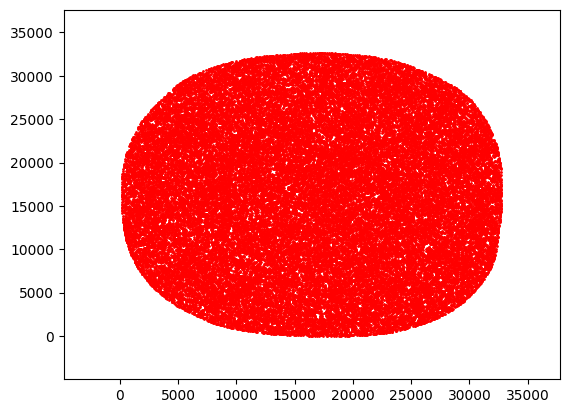

In [83]:
points = testGen.generate()
print(len(points))
fw.plotPoints(points)

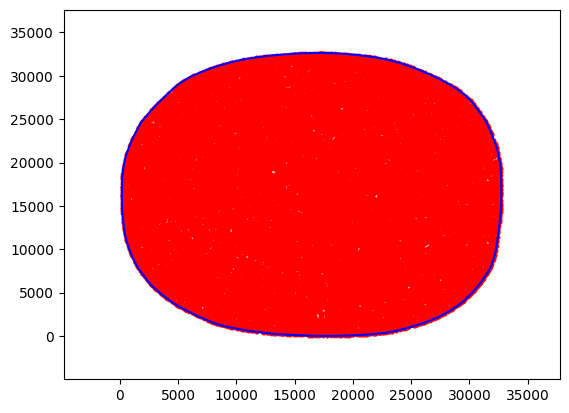

496


In [84]:
hull = grahamscan(points)
fw.drawHull(points,hull)
print(len(hull))